In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge 

diabetes = load_diabetes()

x_train, x_valid, y_train, y_valid = train_test_split(diabetes.data, diabetes.target, random_state=42)

model = Ridge(alpha=1e-2).fit(x_train, y_train)
model.score(x_valid, y_valid)

0.4870585250605408

Permutation Importance 는 하나의 Columns을 선택하고 해당 Columns 의 값을 무작위로 바꾸어 가며 모델의 성능을 확인하는 방법입니다. 만약 중요한 역할을 수행하는 Columns 이라면, 값을 무작위로 바꾸었을 때 정확도나 예측에 있어 매우 큰 역할을 할 것입니다.

In [26]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(model, x_valid, y_valid, 
                              n_repeats=30, 
                              scoring='r2',
                              random_state=42)

for i in imps.importances_mean.argsort()[::-1]:
    if imps.importances_mean[i] - 2 * imps.importances_std[i] > 0:
        print(f'{diabetes.feature_names[i]:<8}'
              f'{imps.importances_mean[i]:.3f}'
              f' +/- {imps.importances_std[i]:.3f}')

s5      0.276 +/- 0.051
bmi     0.227 +/- 0.052
bp      0.070 +/- 0.026
sex     0.066 +/- 0.023


### Permutation Importance $vs$ Random Forest Feature Importance (MDI)

In [46]:
import numpy as np 
import pandas as pd 
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split 

In [36]:
x, y = fetch_openml(
    'titanic', version=1, as_frame=True, return_X_y=True, parser='pandas'
)


x['random_cat'] = np.random.randint(3, size=x.shape[0])
x['random_num'] = np.random.randn(x.shape[0])

cat_cols = ['pclass', 'sex', 'embarked', 'random_cat']
num_cols = ['age', 'sibsp', 'parch', 'fare', 'random_num']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [38]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((981, 15), (328, 15), (981,), (328,))

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_enc = OrdinalEncoder(
    handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1
)

num_pipe = SimpleImputer(strategy='mean')

preprocessing = ColumnTransformer(
    [
        ('cat', cat_enc, cat_cols), 
        ('num', num_pipe, num_cols), 
    ], 
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ('preprocess', preprocessing), 
        ('classifier', RandomForestClassifier(random_state=42)), 
    ]
)

rf.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [45]:
print(f'Random Forest Train Accuracy: {rf.score(x_train, y_train):.3f}')
print(f'Random Forest Test Accuracy: {rf.score(x_test, y_test):.3f}')

Random Forest Train Accuracy: 1.000
Random Forest Test Accuracy: 0.808


In [55]:
feature_names = rf[0].get_feature_names_out()

mdi_imp = pd.Series(
    rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)

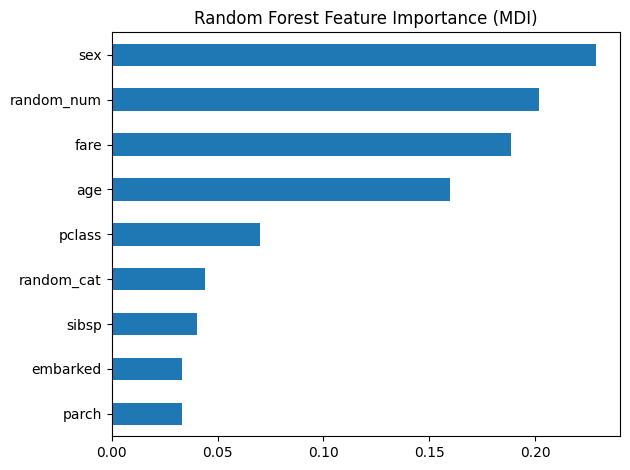

In [59]:
ax = mdi_imp.plot.barh()
ax.set_title('Random Forest Feature Importance (MDI)')
ax.figure.tight_layout()

In [63]:
results = permutation_importance(
    rf, x_test, y_test, n_repeats=30, random_state=42, n_jobs=2
)

Random Forest를 사용하게 되면 Overfitting 현상이 발생하여 무작위로 생성한 Category, Numeric 의 중요도가 높게 나오는 것을 확인할 수 있다. 반면에, Permutation Importance를 사용하게 된다면, 무작위로 생성한 데이터의 중요도는 상대적으로 낮게 측정되는 것을 확인할 수 있다. 

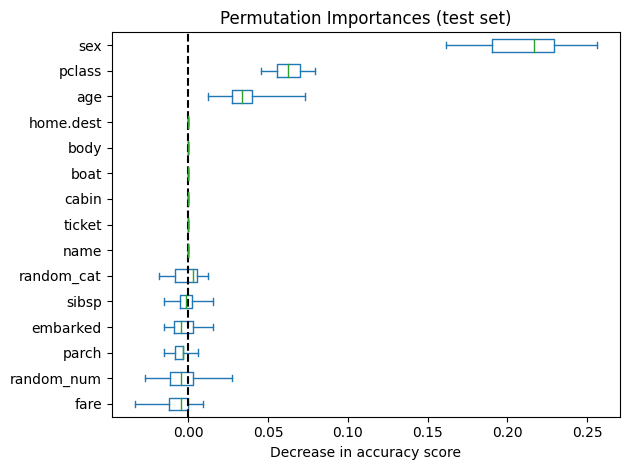

In [64]:
sorted_importances_idx = results.importances_mean.argsort()
importances = pd.DataFrame(
    results.importances[sorted_importances_idx].T, 
    columns=x.columns[sorted_importances_idx], 
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances (test set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

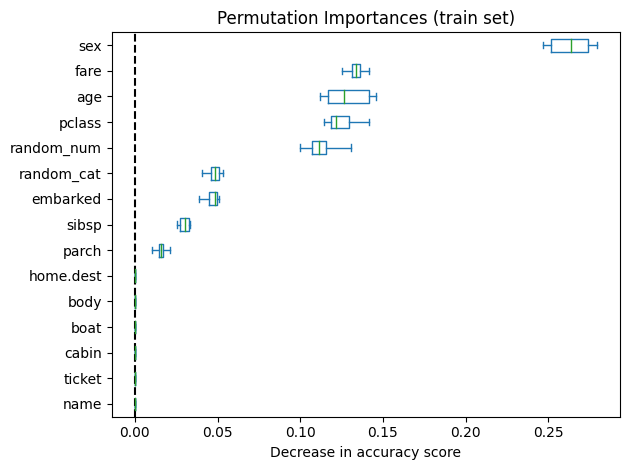

In [67]:
results = permutation_importance(
    rf, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = results.importances_mean.argsort()
importances = pd.DataFrame(
    results.importances[sorted_importances_idx].T,
    columns=x.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()